In [39]:
# this notebook is trying to get a handle on "numerics" of SC2
# make sure we can reproduce modeled and predicted slopes with very close agreement
# and make topo agreement match slope agreement

In [40]:
# first import libraries
import numpy as np
import matplotlib.pyplot as plt

In [41]:
# set up arrays and parameters

dx = 1000 # grid spacing
x = np.arange(0, 10000, dx) # domain length
x_node = x + dx/2

U = 0.001 # uplift rate
phi = 0.55 # sediment porosity
kqs = 0.041 # sediment discharge coefficient
I = 0.01 # intermittency factor
r = 10. # runoff rate
kxb = 25 # valley width coeffecient (a, above)
Pxb = (1/5) # valley width exponent

B = kxb * (x_node**Pxb) # valley width   ## TWEAKED
Q = (r * kxb * x**(6/5))/(1 + Pxb) # discharge  ## WE TWEAKED THIS

# for sc2 specifically
z = np.linspace(1, 0, len(x)) # starting elevation profile
beta = 0.04 # abrasion factor

In [42]:
# calc the slope with the analytical soln

predicted_slope = ((U * B[1:] * x[1:] * (1 - phi))/(1 + (beta * x[1:])) * 1/(kqs*I*Q[1:]))**(6/7)
# predicted_slope = ((U * B[1:] * x[1:])/(1 + (beta * x[1:])) * 1/(kqs*I*Q[1:]))**(6/7)
predicted_topo = -(predicted_slope * x[1:])

In [43]:
# define a fxn for sc2, dzdt = 0

def sc2(dx, x, z, U, phi, kqs, I, r, kxb, Pxb, beta, B, Q, num_steps=3000000):
    
    # set timestep
    dt = (0.5 * dx * dx / (kqs*Q[-1]))
    
    # create arrays
    Qs = np.zeros(len(x))
    E = np.zeros(len(x))
    dzdt = np.zeros(len(x))
    
    # set boundary conditions
    Qs[0] = 0
    #E[-1] = 0
    dzdt[-1] = 0

    for i in range(num_steps):
    
        # calculate slope
        S = np.abs(np.diff(z)/dx)
    
        # calculate sediment transport
        ##Qs[1:] = kqs * I * Q[1:] * S**(7./6.)
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.)
    
        # erosion
        # "old" indexing from [:-1]
        E[:-1] = (1/((1-phi)*B[:-1])) * ((np.diff(Qs)/dx) + (beta * Qs[1:]))
    
        # calculate rate of elevation change
        # "old" indexing of E from [:-1]
        dzdt[:-1] = U - E[:-1]
    
        # update profile
        z += dzdt * dt
    
    return (S, Qs, E, dzdt, z, dt)

In [44]:
# and design a test

sc2_test = [dx, x, z, U, phi, kqs, I, r, kxb, Pxb, beta, B, Q]

# and run it
S, Qs, E, dzdt, model_z, dt = sc2(*sc2_test)

In [45]:
# check to make sure we're at steady state
E

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.   ])

In [46]:
# now make a line with the same slopes as those output from the model
model_topo = -(S * x[1:])

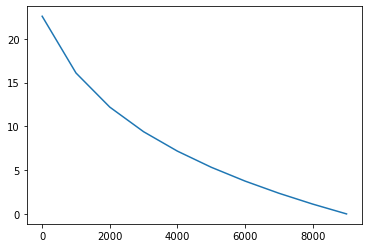

In [47]:
plt.plot(x, model_z)

In [48]:
S

array([0.00647722, 0.00389734, 0.00281012, 0.00221605, 0.00183978,
       0.00157889, 0.00138673, 0.00123891, 0.00112144])

In [49]:
predicted_slope

array([0.00781953, 0.00422813, 0.00296218, 0.00230454, 0.00189805,
       0.00162036, 0.00141783, 0.00126317, 0.00114092])

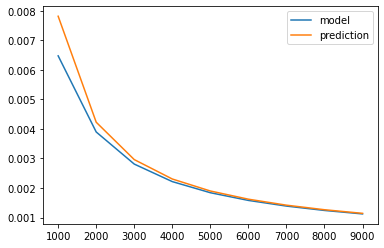

In [50]:
plt.plot(x[1:], S, label = 'model')
plt.plot(x[1:], predicted_slope, label = 'prediction')
plt.legend()

In [51]:
predicted_topo = -(predicted_slope * x[1:]) # + model_z[0]

In [52]:
baselevel_difference = model_z[-1] - predicted_topo[-1]

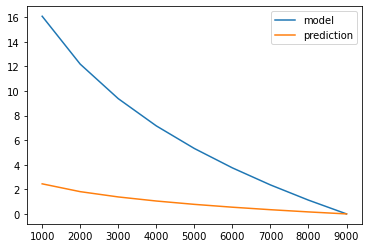

In [53]:
plt.plot(x[1:], model_z[1:], label = 'model')
plt.plot(x[1:], predicted_topo + baselevel_difference, label = 'prediction')
plt.legend()